In [1]:
"""Загрузка основных библиотек"""
import os, cv2, keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Подготавливаем тренировочную и тестовую выборки, вырезая аннотированных куриц из изображений в датасете.

In [2]:
"""Подгрузка файлов проекта"""
!git clone https://github.com/Laz-eg/Sick-chicken-detection.git

Cloning into 'Sick-chicken-detection'...
remote: Enumerating objects: 3186, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 3186 (delta 0), reused 19 (delta 0), pack-reused 3167
Receiving objects: 100% (3186/3186), 181.82 MiB | 13.89 MiB/s, done.
Updating files: 100% (3158/3158), done.


In [3]:
"""Загрузка аннотаций и их предобработка"""

annot_train = pd.read_csv('/content/Sick-chicken-detection/data/sick chickens/train/_annotations.csv', names=['filename', 'x1', 'y1', 'x2', 'y2', 'class'])
annot_valid = pd.read_csv('/content/Sick-chicken-detection/data/sick chickens/valid/_annotations.csv', names=['filename', 'x1', 'y1', 'x2', 'y2', 'class'])

print('Аннотации загружены, ', annot_train.shape, annot_valid.shape)

annot_train.head()

Аннотации загружены,  (190, 6) (60, 6)


,filename,x1,y1,x2,y2,class
0,images-22-_jpeg.rf.3307dd18898c4ed38957f4f5315...,314,48,539,563,sickChicken
1,ben-moreland-auijD19Byq8-unsplash_jpg.rf.042d0...,187,178,505,640,healthyChicken
2,ben-moreland-auijD19Byq8-unsplash_jpg.rf.042d0...,0,106,303,405,healthyChicken
3,ben-moreland-auijD19Byq8-unsplash_jpg.rf.042d0...,116,61,338,188,healthyChicken
4,ben-moreland-auijD19Byq8-unsplash_jpg.rf.042d0...,503,82,640,202,healthyChicken


In [4]:
""" Анализ размера изображений"""

area = pd.DataFrame()
area['w'] = annot_train['x2'] - annot_train['x1']
area['h'] = annot_train['y2'] - annot_train['y1']
area['S'] = area['w'] * area['h']

display(area.loc[(area['w'] > 100) & (area['h'] > 100)])
display(area.head())
display(area.mean())

,w,h,S
0,225,515,115875
1,318,462,146916
2,303,299,90597
3,222,127,28194
4,137,120,16440
...,...,...,...
185,499,568,283432
186,607,582,353274
187,507,632,320424
188,404,387,156348


,w,h,S
0,225,515,115875
1,318,462,146916
2,303,299,90597
3,222,127,28194
4,137,120,16440


w       285.626316
h       368.552632
S    127236.694737
dtype: float64

Большинство (167 из 190) изображений имеют размеры большие 100х100, значит при перемасштабировании к виду 224х224 качество не должно заметно пострадать и сказаться на обучении модели.

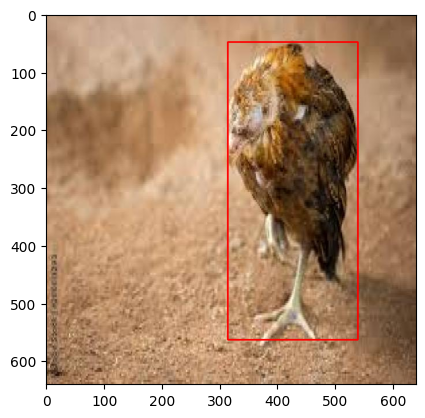

In [5]:
"""Просмотр аннотируемых частей изображения"""

img = cv2.imread('/content/Sick-chicken-detection/data/sick chickens/train/' + annot_train.iloc[0][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x1, y1, x2, y2 = annot_train.iloc[0][1], annot_train.iloc[0][2], annot_train.iloc[0][3], annot_train.iloc[0][4]
cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.imshow(img)

In [6]:
"""Формирование данных выборки: вырезаем по аннотациям картинки с курицами и маркируем"""
from sklearn.model_selection import train_test_split

# Train + Test
train_path = '/content/Sick-chicken-detection/data/sick chickens/train/'

X = []
y = []

for i in range(annot_train.shape[0]):
  path, x1, y1, x2, y2, marker = annot_train.iloc[i]
  img = cv2.imread(train_path + path)
  new_img = img[y1:y2, x1:x2]
  new_img = cv2.resize(new_img, (224, 224), interpolation = cv2.INTER_AREA)
  X.append(new_img)
  if marker == 'sickChicken':
    marker = np.array([0, 1])
  else:
    marker = np.array([1, 0])
  y.append(marker)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)


# Valid
valid_path = '/content/Sick-chicken-detection/data/sick chickens/valid/'

X_valid = []
y_valid = []

for i in range(annot_valid.shape[0]):
  path, x1, y1, x2, y2, marker = annot_valid.iloc[i]
  img = cv2.imread(valid_path + path)
  new_img = img[y1:y2, x1:x2]
  new_img = cv2.resize(new_img, (224, 224), interpolation = cv2.INTER_AREA)
  X_valid.append(new_img)
  if marker == 'sickChicken':
    marker = np.array([0, 1]) # больная
  else:
    marker = np.array([1, 0]) # здоровая
  y_valid.append(marker)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

Здесь были использованы пометки классов 'sickChicken' --> [1, 0]; 'healthyChicken' --> [0, 1]. Это позволит модели выводить вероятности принадлежности обоим классам.

(152, 2) (38, 2)


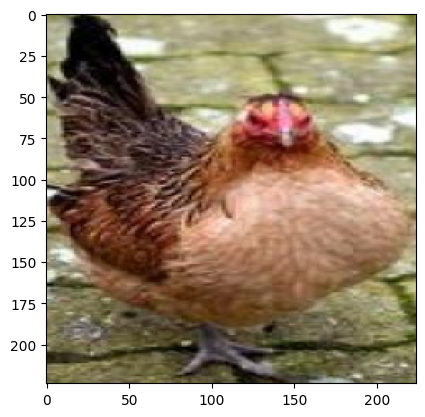

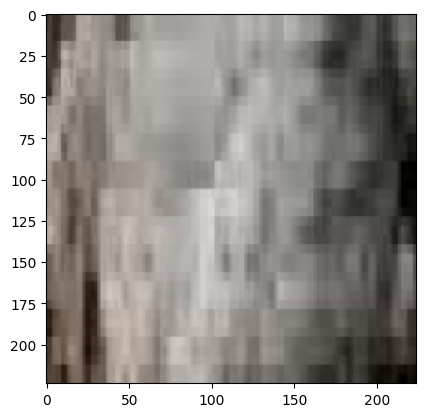

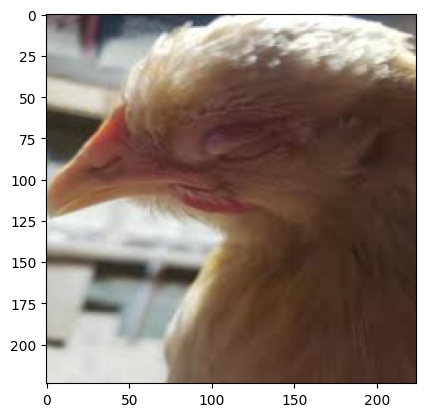

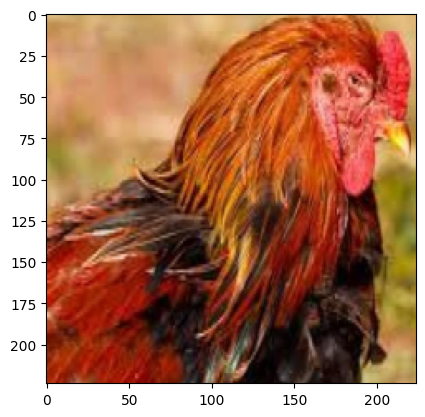

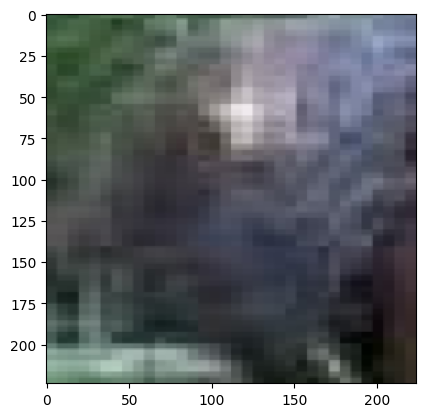

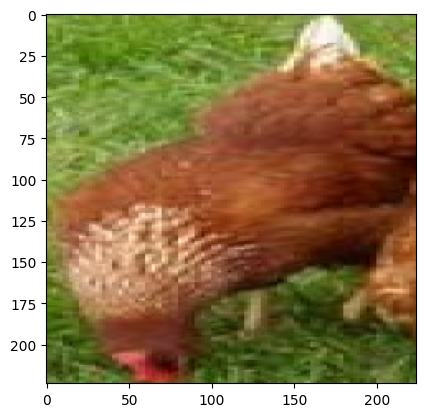

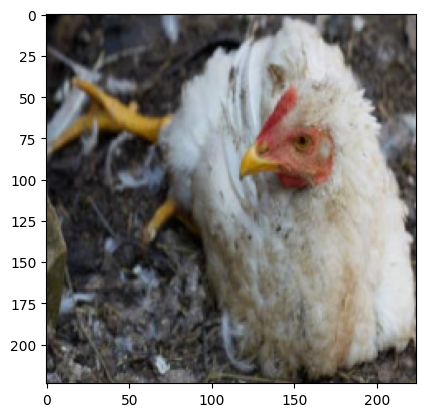

In [7]:
"""Просмотр тестовых переформатированных изображений"""

print(y_train.shape, y_test.shape)

for i in range(X_test.shape[0]//5):
  img = X_test[i]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()

In [8]:
"""Загружаем функции для создания модели"""
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

In [9]:
"""Неудачная модель"""
# Построение модели: формируем слои нейросети (упрощение модели VGG16).

# if K.image_data_format() == 'channels_first': # для сохранения упорядочевания весов при переключении модели с одного формата данных на другой
#     input_shape = (3, 224, 224)
# else:
#     input_shape = (224, 224, 3)

# classifier = Sequential() # input (N, 224, 224, 3)

# classifier.add(Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape))
# classifier.add(MaxPooling2D((2, 2), strides=(2, 2))) # 224 --> 112

# classifier.add(Conv2D(64, (3,3), activation="relu", padding="same"))
# classifier.add(MaxPooling2D((2, 2), strides=(2, 2))) # 112 --> 56

# classifier.add(Conv2D(128, (3,3), activation="relu", padding="same"))
# classifier.add(MaxPooling2D((2, 2), strides=(2, 2))) # 56 --> 28

# classifier.add(Conv2D(256, (3,3), activation="relu", padding="same"))
# classifier.add(Conv2D(256, (3,3), activation="relu", padding="same"))
# classifier.add(MaxPooling2D((2, 2), strides=(2, 2))) # 28 --> 14

# classifier.add(Conv2D(256, (3,3), activation="relu", padding="same"))
# classifier.add(Conv2D(256, (3,3), activation="relu", padding="same"))
# classifier.add(MaxPooling2D((2, 2), strides=(2, 2))) # 14 --> 7

# classifier.add(Flatten())
# classifier.add(Dense(2048, activation="relu"))
# classifier.add(Dense(2048, activation="relu"))
# classifier.add(Dense(2, activation="softmax"))

# classifier.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

'Неудачная модель'

In [10]:
"""Построение модели классификатора на основе VGG16(19)"""
from keras.applications.vgg19 import VGG19
basic_model = VGG19(weights = 'imagenet', include_top = True) # импортируем архитектуру и начальные параметры

# basic_model = VGG16(weights = 'imagenet', include_top = True) # импортируем архитектуру и начальные параметры

574710816/574710816 [==============================] - 25s 0us/step


Улучшение качества модели может быть достигнуто за счет выбора оптимальных параметров:

In [30]:
"""Параметры для оптимизации"""
lr = 0.00001 # best = 0.00001 -- скорость обучения оптимизатора

train_batch_size = 8 # best = 8 -- размер входных пачек изображений при обучении 10
train_steps = 19  # best = 19 -- количество шагов обучения 20

valid_batch_size = 8 # best = 8 -- размер входных пачек изображений при валидации
valid_steps = 7 # best = 7 -- количество шагов валидации

num_epochs = 2 # best = 2 -- число эпох обучения

if train_batch_size*train_steps > X_train.shape[0]:
  print('Выбрано слишком много шагов для тренировочной выборки')
  train_steps = X_train.shape[0]//train_batch_size
  print(f'Количество шагов уменьшено до {train_steps}')

if valid_batch_size*valid_steps > X_valid.shape[0]:
  print('Выбрано слишком много шагов для валидационной выборки')
  valid_steps = X_valid.shape[0]//valid_batch_size
  print(f'Количество шагов уменьшено до {valid_steps}')

In [31]:
for layers in (basic_model.layers)[:15]:
    layers.trainable = False
X = basic_model.layers[-2].output
predictions = Dense(2, activation = "softmax")(X)
classifier = Model(inputs = basic_model.input, outputs = predictions)
opt = Adam(learning_rate = lr) ### Оптимизируемый параметр
classifier.compile(loss = keras.losses.binary_crossentropy, optimizer = opt, metrics=["accuracy"])

In [32]:
classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [33]:
"""Построение генераторов изображений для обучения нейросети"""

print(X_train.shape)
print(X_valid.shape)

trdata = ImageDataGenerator()
traindata = trdata.flow(x = X_train, y = y_train, batch_size=train_batch_size)
vdata = ImageDataGenerator()
validdata = vdata.flow(x = X_valid, y = y_valid, batch_size=valid_batch_size)

(152, 224, 224, 3)
(60, 224, 224, 3)


In [34]:
"""Обучение модели"""

classifier.fit(
    traindata,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=validdata,
    validation_steps=valid_steps)


Epoch 1/2
19/19 [==============================] - 6s 173ms/step - loss: 0.3805 - accuracy: 0.8618 - val_loss: 0.3932 - val_accuracy: 0.8750
Epoch 2/2
19/19 [==============================] - 3s 136ms/step - loss: 0.0202 - accuracy: 0.9868 - val_loss: 0.5046 - val_accuracy: 0.8036


In [35]:
"""Тестирование обученной модели"""
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

y_predict = classifier.predict(X_test)
y_predict_rounded = np.round(y_predict, decimals=0).astype(int) # округление для получения ответа, какой это класс

length = y_predict.shape[0]*y_predict.shape[1]  # "выпрямление" массива в одномерный для подсчета метрик
y_test_1d = y_test.reshape(length, )[0::2]
y_predict_1d = y_predict_rounded.reshape(length, )[0::2]

accuracy = accuracy_score(y_test_1d, y_predict_1d)
precision = precision_score(y_test_1d, y_predict_1d)
recall = recall_score(y_test_1d, y_predict_1d)
matrix = confusion_matrix(y_test_1d, y_predict_1d)

print(f"accuracy = {accuracy}")
print(f"precision = {precision}")
print(f"recall = {recall}")
print('')
print('confusion matrix:')
display(matrix)

2/2 [==============================] - 0s 146ms/step
accuracy = 0.8421052631578947
precision = 0.9
recall = 0.8181818181818182

confusion matrix:


array([[14,  2],
       [ 4, 18]])

In [36]:
"""Сохранение успешной модели"""

# classifier.save('classifier_84.h5')

'Сохранение успешной модели'

In [37]:
# from google.colab import drive
# drive.mount('/content/drive')